In [1]:
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# بارگذاری مدل و توکنایزر
model_path = "./persian_bert_tiny_final_model_large_2"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModel.from_pretrained(model_path)
model.eval() # حالت ارزیابی

def get_embedding(sentence, word_to_check):
    inputs = tokenizer(sentence, return_tensors="pt", truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
        last_hidden_states = outputs.last_hidden_state

    # پیدا کردن توکن مورد نظر و گرفتن embedding آن
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
    # توجه: ممکن است کلمه به چند توکن WordPiece شکسته شود. اینجا فقط اولین توکن را در نظر می‌گیریم.
    word_tokens = tokenizer.tokenize(word_to_check)
    if word_tokens and word_tokens[0] in tokens:
        start_idx = tokens.index(word_tokens[0])
        # ممکن است چند توکن باشد، اینجا فقط اولین توکن را می‌گیریم یا میانگین بگیریم
        word_embedding = last_hidden_states[0, start_idx].unsqueeze(0).numpy() # شکل: (1, hidden_size)
        return word_embedding, tokens[start_idx]
    else:
        # اگر توکن پیدا نشد
        print(f"Warning: Word '{word_to_check}' or its tokenization not found in sentence '{sentence}'.")
        # ممکن است بخواهید اولین توکن بعد از CLS را برگردانید یا None
        # برای سادگی، اولین توکن غیر CLS/SEP را می‌گیریم
        for i, token in enumerate(tokens):
            if token not in [tokenizer.cls_token, tokenizer.sep_token]:
                 return last_hidden_states[0, i].unsqueeze(0).numpy(), token
        return None, None

# مثال
sentence1 = "این یک متن فارسی برای تست مدل است."
sentence2 = "این یک متن فارسی برای آزمایش مدل است."
sentence3 = "آسمان آبی بسیار زیبا است."

word1 = "تست"
word2 = "آزمایش"
word3 = "زیبا"

emb1, tok1 = get_embedding(sentence1, word1)
emb2, tok2 = get_embedding(sentence2, word2)
emb3, tok3 = get_embedding(sentence3, word3)

if emb1 is not None and emb2 is not None:
    similarity_12 = cosine_similarity(emb1, emb2)[0][0]
    print(f"Similarity between '{tok1}' in '{sentence1}' and '{tok2}' in '{sentence2}': {similarity_12:.4f}")

if emb1 is not None and emb3 is not None:
    similarity_13 = cosine_similarity(emb1, emb3)[0][0]
    print(f"Similarity between '{tok1}' in '{sentence1}' and '{tok3}' in '{sentence3}': {similarity_13:.4f}")

# می‌توانید یک ماتریس کامل شباهت برای چند کلمه بسازید و آن را چاپ یا نمودار کنید.

/home/homemsaa/tf/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-10-18 23:35:23.929116: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-18 23:35:24.225958: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-18 23:35:25.346358: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numer

Similarity between 'تست' in 'این یک متن فارسی برای تست مدل است.' and 'آزمایش' in 'این یک متن فارسی برای آزمایش مدل است.': 0.7634
Similarity between 'تست' in 'این یک متن فارسی برای تست مدل است.' and 'زیبا' in 'آسمان آبی بسیار زیبا است.': 0.4528


/home/homemsaa/tf/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-10-20 06:40:50.040984: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-20 06:40:50.080798: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-20 06:40:51.033356: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numer

Found 17 embeddings for visualization.


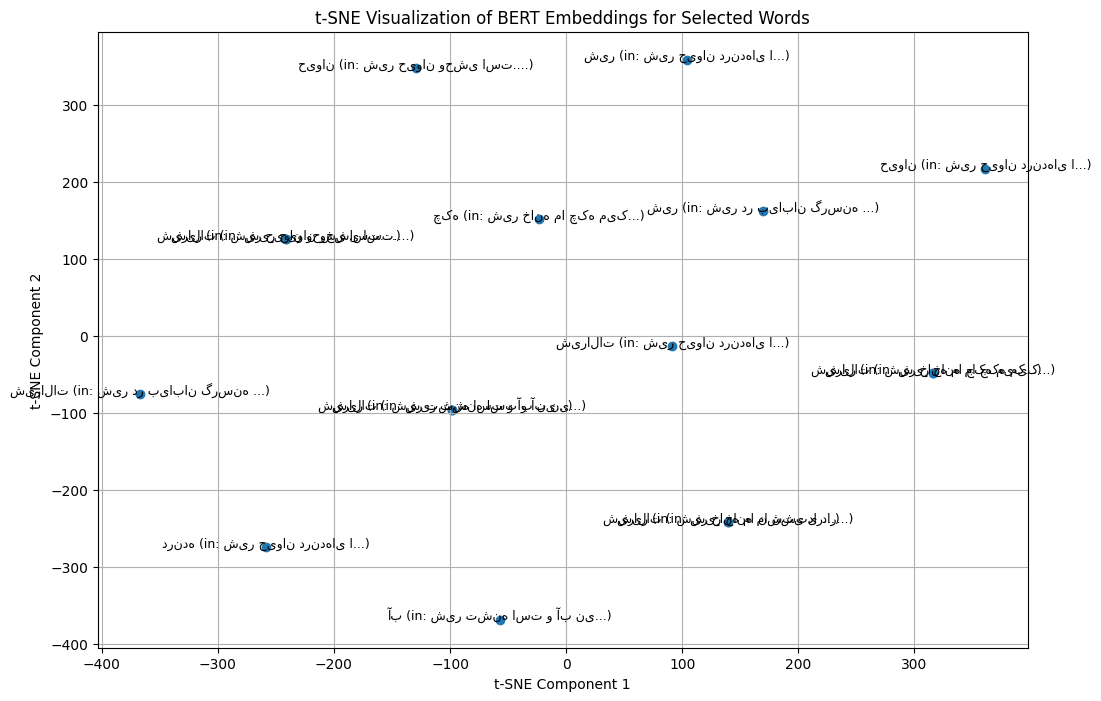

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# بارگذاری مدل و توکنایزر
import os
model_path = os.path.abspath("persian_bert_tiny_final_model_large_2")
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModel.from_pretrained(model_path)
model.eval()

# لیست کلمات یا جملات نمونه
sentences = [
    "شیر در بیابان گرسنه است.",
    "شیر حیوان وحشی است.",
    "شیر خانه ما چکه می‌کند.",
    "شیر تشنه است و آب نیاز دارد.",
    "شیر خانه ما نشتی دارد.",
    "شیر حیوان درنده‌ای است.",

]
words_to_visualize = ["شیر","آب","حیوان","درنده","شیرالات","چکه"] # تعداد کلمات بیشتر از تعداد جملات

embeddings = []
labels = []

for sent in sentences:
    inputs = tokenizer(sent, return_tensors="pt", truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
        last_hidden_states = outputs.last_hidden_state

    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
    for word in words_to_visualize:
        word_tokens = tokenizer.tokenize(word)
        if word_tokens and word_tokens[0] in tokens:
             start_idx = tokens.index(word_tokens[0])
             emb = last_hidden_states[0, start_idx].numpy() # شکل: (hidden_size,)
             embeddings.append(emb)
             labels.append(f"{word} (in: {sent[:20]}...)")
             # break # اگر فقط اولین ورودی هر کلمه در هر جمله مهم است، این را فعال کنید
             # اما اگر هر ورودی از هر کلمه در هر جمله مهم است، این را غیرفعال کنید
             # در این مثال، احتمالاً فقط یک بار هر کلمه در هر جمله ظاهر می‌شود،
             # بنابراین break تفاوت چندانی نمی‌کند، مگر اینکه کلمات تکراری باشند.
             # اما در هر صورت، این کد ممکن است کمتر از 6 embedding ایجاد کند اگر کلمات پیدا نشوند.

# --- اصلاح: اطمینان از وجود embedding برای نمایش ---
if len(embeddings) == 0:
    print("No embeddings found for the specified words in the sentences.")
else:
    print(f"Found {len(embeddings)} embeddings for visualization.")
    embeddings = np.array(embeddings)

    # --- اصلاح: تنظیم perplexity ---
    # تعداد نمونه‌ها (len(embeddings)) را چک کنید و perplexity مناسب انتخاب کنید
    # معمولاً perplexity باید کمتر از len(embeddings) باشد.
    # برای len(embeddings) = 6، مثلاً perplexity = min(5, len(embeddings) - 1) خوب است.
    calculated_perplexity = min(30, len(embeddings) - 1) # حداکثر 30، اما اگر کمتر از 6 بود، یکی کمتر از تعداد کل
    if calculated_perplexity <= 0:
        print("Not enough samples for t-SNE (need at least 2).")
    else:
        # اعمال t-SNE
        tsne = TSNE(n_components=2, random_state=42, perplexity=calculated_perplexity) # <-- perplexity اضافه شد
        embeddings_2d = tsne.fit_transform(embeddings)

        # نمایش نمودار
        plt.figure(figsize=(12, 8))
        plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])
        for i, label in enumerate(labels):
            plt.annotate(label, (embeddings_2d[i, 0], embeddings_2d[i, 1]), fontsize=9, ha='center')
        plt.title("t-SNE Visualization of BERT Embeddings for Selected Words")
        plt.xlabel("t-SNE Component 1")
        plt.ylabel("t-SNE Component 2")
        plt.grid(True)
        
        plt.show()


Some weights of BertModel were not initialized from the model checkpoint at ./persian_bert_tiny_final_model_large_2 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


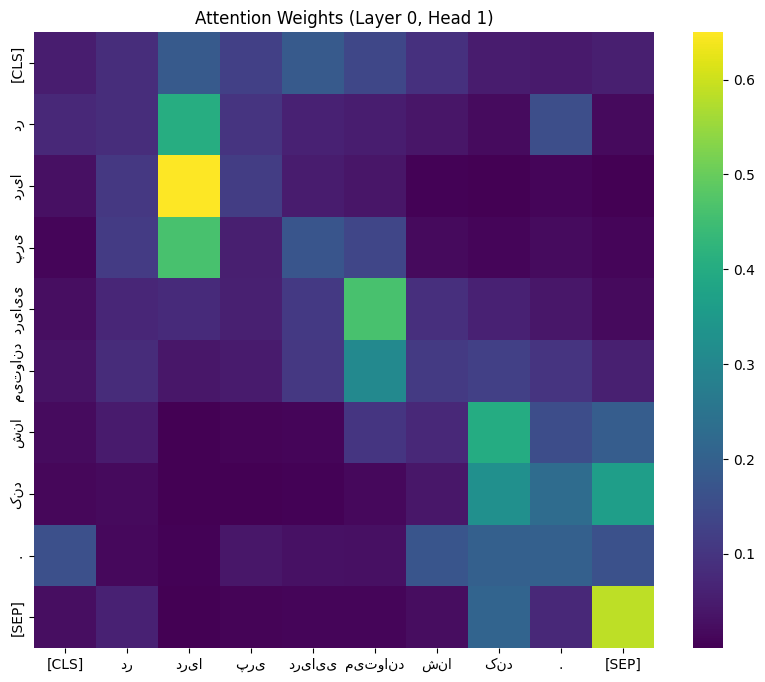

In [6]:
import torch
from transformers import AutoTokenizer, AutoModel
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# بارگذاری مدل و توکنایزر
model_path = "./persian_bert_tiny_final_model_large_2"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModel.from_pretrained(model_path, output_attentions=True) # فعال کردن خروجی attention
model.eval()

sentence = "در دریا پری دریایی می‌تواند شنا کند."
inputs = tokenizer(sentence, return_tensors="pt", truncation=True, max_length=512)

with torch.no_grad():
    outputs = model(**inputs)
    attentions = outputs.attentions # یک تاپل از تنسورهای attention برای هر لایه

# می‌توانید attention یک لایه خاص (مثلاً آخرین لایه) و یک هدر خاص را نشان دهید
layer_idx = -1 # آخرین لایه
head_idx = 0   # اولین هدر
attention = attentions[layer_idx][0, head_idx].numpy() # [batch_size=0, head_idx, seq_len, seq_len]

# نمایش Heatmap
tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
plt.figure(figsize=(10, 8))
sns.heatmap(attention, xticklabels=tokens, yticklabels=tokens, cmap='viridis')
plt.title(f'Attention Weights (Layer {layer_idx+1}, Head {head_idx+1})')
plt.show()

In [7]:
attention

array([[5.11385836e-02, 8.30200538e-02, 1.80622637e-01, 1.24547884e-01,
        1.80762589e-01, 1.38956994e-01, 9.03738216e-02, 5.08901328e-02,
        4.48977202e-02, 5.47896288e-02],
       [7.27636144e-02, 8.23898911e-02, 4.05043662e-01, 9.82909799e-02,
        6.05874509e-02, 5.21912090e-02, 3.81882451e-02, 1.87113266e-02,
        1.53912663e-01, 1.79209225e-02],
       [2.58502606e-02, 1.04629084e-01, 6.50160968e-01, 1.15881503e-01,
        4.94925678e-02, 3.68881561e-02, 4.01235372e-03, 1.99470832e-03,
        9.97787900e-03, 1.11245119e-03],
       [9.08413343e-03, 1.13882586e-01, 4.60626751e-01, 5.52388467e-02,
        1.72017545e-01, 1.36437684e-01, 1.56964976e-02, 9.80900694e-03,
        1.89011712e-02, 8.30572471e-03],
       [2.36575250e-02, 6.97843954e-02, 7.86128268e-02, 5.81221282e-02,
        1.07326023e-01, 4.59954619e-01, 8.76823440e-02, 5.94869070e-02,
        3.91854644e-02, 1.61879007e-02],
       [3.15943696e-02, 7.99758509e-02, 3.97892743e-02, 4.83077392e-02,
   

In [8]:
tokens

['[CLS]', 'در', 'دریا', 'پری', 'دریایی', 'میتواند', 'شنا', 'کند', '.', '[SEP]']

In [4]:
import torch
import numpy as np
import os
from transformers import AutoTokenizer, AutoModel
from sklearn.manifold import TSNE
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

# --- بارگذاری مدل و توکنایزر ---
model_path = os.path.abspath("persian_bert_tiny_final_model_large_2")
tokenizer = AutoTokenizer.from_pretrained(model_path, local_files_only=True)
model = AutoModel.from_pretrained(model_path, local_files_only=True)
model.eval()

# --- داده‌های ورودی ---

# لیست کلمات یا جملات نمونه
sentences = [
    "شیر در بیابان گرسنه است.",
    "شیر حیوان وحشی است.",
    "شیر خانه ما چکه می‌کند.",
    "شیر تشنه است و آب نیاز دارد.",
    "شیر خانه ما نشتی دارد.",
    "شیر حیوان درنده‌ای است.",

]
words_to_visualize = ["شیر","آب","حیوان","درنده","شیرالات","چکه"] # تعداد کلمات بیشتر از تعداد جملات


# --- استخراج embeddingها ---
embeddings = []
labels = []

for sent in sentences:
    inputs = tokenizer(sent, return_tensors="pt", truncation=True, max_length=256)
    with torch.no_grad():
        outputs = model(**inputs)
        last_hidden_states = outputs.last_hidden_state  # [1, seq_len, hidden_size]

    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
    for word in words_to_visualize:
        word_tokens = tokenizer.tokenize(word)
        if word_tokens and word_tokens[0] in tokens:
            start_idx = tokens.index(word_tokens[0])
            emb = last_hidden_states[0, start_idx].numpy()
            embeddings.append(emb)
            labels.append(f"{word} (in: {sent[:20]}...)")

# --- بررسی وجود داده ---
if len(embeddings) == 0:
    print("No embeddings found!")
else:
    print(f"Found {len(embeddings)} embeddings.")
    embeddings = np.array(embeddings)

    # --- t-SNE ---
    n_samples = len(embeddings)
    if n_samples < 2:
        print("Need at least 2 samples for t-SNE.")
    else:
        perplexity = min(30, n_samples - 1) if n_samples > 1 else 1
        tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity)
        embeddings_2d = tsne.fit_transform(embeddings)

        # --- ساخت نمودار با Plotly ---
        fig = go.Figure()

        # اضافه کردن نقاط
        fig.add_trace(go.Scatter(
            x=embeddings_2d[:, 0],
            y=embeddings_2d[:, 1],
            mode='markers+text',
            text=labels,
            textposition="top center",
            marker=dict(size=10, color='lightblue', line=dict(width=1, color='black')),
            hovertemplate='%{text}<extra></extra>'
        ))

        fig.update_layout(
            title="t-SNE Visualization of BERT Embeddings for Selected Words",
            xaxis_title="t-SNE Component 1",
            yaxis_title="t-SNE Component 2",
            width=900,
            height=700,
            showlegend=False,
            font=dict(size=12),
            plot_bgcolor='white',
            xaxis=dict(showgrid=True, gridcolor='lightgray'),
            yaxis=dict(showgrid=True, gridcolor='lightgray')
        )

        # --- ذخیره به عنوان HTML استاتیک ---
        output_file = "embeddings_tsne.html"
        pio.write_html(fig, file=output_file, full_html=True, include_plotlyjs='cdn')
        print(f"Interactive plot saved to: {os.path.abspath(output_file)}")

Some weights of BertModel were not initialized from the model checkpoint at /home/homemsaa/Documents/GitHub/bert/persian_bert_tiny_final_model_large_2 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Found 10 embeddings.
Interactive plot saved to: /home/homemsaa/Documents/GitHub/bert/embeddings_tsne.html
